In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

# assumes observations from GBIF and has 'decimalLongitude' and 'decimalLatitude' keys
def create_buffers(obs_df: pd.DataFrame, radius: float) -> gpd.GeoDataFrame:
    """
    Creates 1 km vector buffers around observation points.

    Args:
        obs_df (pd.DataFrame): DataFrame containing GBIF observation coordinates 
                               with 'decimalLongitude' and 'decimalLatitude' columns.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame with original points and their corresponding 1 km buffers.
    """
    geometry = [Point(lon, lat) for lon, lat in zip(obs_df['decimalLongitude'], obs_df['decimalLatitude'])]
    gdf = gpd.GeoDataFrame(obs_df, geometry=geometry, crs="EPSG:4326")

    gdf_utm = gdf.to_crs("EPSG:32616")
    gdf_utm['buffers'] = gdf_utm.geometry.buffer(radius)
    return gdf_utm

gbif_observations_file_path = '..\\data\\0007450-250310093411724.csv'
df = pd.read_csv(gbif_observations_file_path, sep='\t')

gdf_utm = create_buffers(df, radius=1000)
gdf_utm.head()

C:\Users\julia\AppData\Local\Temp\ipykernel_26928\2991995874.py:25: DtypeWarning: Columns (23,24,25,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(gbif_observations_file_path, sep='\t')


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue,geometry,buffers
0,5077538344,13dacd48-5790-4b99-bf04-08b23922e8aa,1a3fdf17-bdc7-40d9-a5ca-82bff6b2237d,Plantae,Tracheophyta,Magnoliopsida,Malpighiales,Euphorbiaceae,Croton,Croton glandulosus,...,CC_BY_NC_4_0,NaN,Thomas G. Hartley,NaN,NaN,2025-03-07T23:02:57.962Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,POINT (243029.032 4646644.009),"POLYGON ((244029.032 4646644.009, 244024.216 4..."
1,5077539464,13dacd48-5790-4b99-bf04-08b23922e8aa,e8d7c04d-26c9-4e28-9635-108bc3078aec,Plantae,Tracheophyta,Magnoliopsida,Malpighiales,Euphorbiaceae,Croton,Croton monanthogynus,...,CC_BY_NC_4_0,NaN,"van Ee, Benjamin W.; van Ee, Melissa; van Ee, ...",NaN,NaN,2025-03-07T23:02:58.667Z,StillImage,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (332062.072 4217895.205),"POLYGON ((333062.072 4217895.205, 333057.257 4..."
2,5077539917,13dacd48-5790-4b99-bf04-08b23922e8aa,6e4dfd06-3e35-4c43-b540-fa7400717434,Plantae,Tracheophyta,Liliopsida,Asparagales,Orchidaceae,Cypripedium,Cypripedium reginae,...,CC_BY_NC_4_0,NaN,R.A. Harper,NaN,NaN,2025-03-07T23:03:00.179Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,POINT (430663.818 4678834.773),"POLYGON ((431663.818 4678834.773, 431659.002 4..."
3,5077542798,13dacd48-5790-4b99-bf04-08b23922e8aa,35bb3f31-dd54-4912-9434-53d9130e1a92,Plantae,Tracheophyta,Liliopsida,Asparagales,Orchidaceae,Galearis,Galearis spectabilis,...,CC_BY_NC_4_0,NaN,E.T. Harper,NaN,NaN,2025-03-07T23:03:02.228Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,POINT (222897.066 4612478.101),"POLYGON ((223897.066 4612478.101, 223892.251 4..."
4,5077544672,13dacd48-5790-4b99-bf04-08b23922e8aa,d306d12f-3ae2-4ab1-9dca-efda2650fedc,Plantae,Tracheophyta,Magnoliopsida,Ericales,Ericaceae,Vaccinium,Vaccinium arboreum,...,CC_BY_NC_4_0,NaN,G. S. Winterringer,NaN,NaN,2025-03-07T23:03:02.821Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,POINT (382753.826 4162291.368),"POLYGON ((383753.826 4162291.368, 383749.011 4..."


In [18]:
# extract_dir = "..\us_il_shapefiles"
# zip_file_path = os.path.join(extract_dir, "IL_BNDY_State.zip")

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# shapefile_path = os.path.join(extract_dir, "IL_BNDY_State_Ln.shp")
# il_gdf = gpd.read_file(shapefile_path)

#for more precise illinois state boundaries--didn't end up using

il_coordinates = [
    (-87.5292755, 41.7567867),(-87.65849562959642, 42.07535913962207),(-87.8202036456503, 42.29139449472285),(-87.80023830534141, 42.39062280521323),
    (-87.79487855575071, 42.49185408277431),(-90.64281757866335, 42.50852726394397),(-90.65551555943709, 42.47936856524973),(-91.3602079772792, 39.78736513631642),
    (-90.1854151112902, 38.82668498499032),(-90.18548064080385, 38.59781705568738),(-90.36966801607325, 38.23430194721997),(-89.24896546412347, 37.01952178474121),(-88.46974294326039, 37.0584455654243),
    (-87.56754675242111, 38.606499187711364),(-87.53189667394427, 39.35454637993529)
]

il_polygon = Polygon(il_coordinates)
gdf_il = gpd.GeoDataFrame({'geometry': [il_polygon]})

In [18]:
import numpy as np


In [17]:
import numpy as np

def create_control_buffers(bbox: list[tuple[int, int]],
                           radius: float) -> gpd.GeoDataFrame:
    """
    Generates random control buffers with a 1km radius within a bounding box.

    Args:
        bbox (tuple): Bounding box coordinates (min_x, min_y, max_x, max_y).

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame with random points and their corresponding 1 km buffers.
    """
    illinois_bbox = Polygon(bbox)
    min_x, min_y, max_x, max_y = illinois_bbox.bounds

    np.random.seed(42)

    n_controls = len(gdf_utm)
    random_points = [
        Point(np.random.uniform(min_x, max_x),
            np.random.uniform(min_y, max_y))
        for _ in range(n_controls)
    ]
    gdf_controls = gpd.GeoDataFrame(geometry=random_points, crs="EPSG:4326")
    gdf_controls['buffers'] = gdf_controls.to_crs("EPSG:32616").buffer(radius)

    return gdf_controls


gdf_controls = create_control_buffers(il_coordinates, radius=1000)
gdf_controls.head()

NameError: name 'il_coordinates' is not defined

In [20]:
import zipfile
import os

# zip_file_path = "../_NLCD_519W897hevlAKeQOwMVE.zip"
# extract_dir = "../nlcd_data"
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)


In [21]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject

    # this function is unecessary because we should be reprojecting
    # the vectors onto the raster NLCD data, as it is in the Albers Equal-Area 
    # conic projection, while WGS-84 distorts area
    # also saves from having to store two versions of the raster

def reproject_raster(input_path: str, output_path: str, dst_crs: str):
    """
    Reprojects a raster file to a specified coordinate reference system (CRS).

    Args:
        input_path (str): Path to the input raster file.
        output_path (str): Path to save the reprojected raster file.
        dst_crs (str): The target coordinate reference system in PROJ or EPSG format (e.g., 'EPSG:4326').

    Returns:
        None
    """
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_path, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=rasterio.enums.Resampling.nearest
            )

dst_crs = ""
extract_dir = "..\processed_rasters"
in_tiff_file_path = '..\\nlcd_data\\Annual_NLCD_LndCov_2023_CU_C1V0_519W897hevlAKeQOwMVE.tiff'
out_tif_file_path = os.path.join(extract_dir, "IL_NLCD_2023_WGS84.tiff")
# reproject_raster(in_tiff_file_path, out_tif_file_path, dst_crs=dst_crs)


<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
C:\Users\julia\AppData\Local\Temp\ipykernel_27128\3764666032.py:45: SyntaxWarning: invalid escape sequence '\p'
  extract_dir = "..\processed_rasters"


In [7]:
import rasterio
from rasterio.crs import CRS

# define custom CRS
nlcd_custom_wkt = """
PROJCS["AEA        WGS84",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["latitude_of_center",23],
    PARAMETER["longitude_of_center",-96],
    PARAMETER["standard_parallel_1",29.5],
    PARAMETER["standard_parallel_2",45.5],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],AXIS["Northing",NORTH]]
"""
custom_crs = rasterio.crs.CRS.from_wkt(nlcd_custom_wkt)
gdf_aea = gdf_utm.to_crs(custom_crs)
#gdf_controls_aea = gdf_controls.to_crs(custom_crs)
#gdf_il = gdf_il.set_crs(custom_crs)

gdf_aea['buffers'] = gdf_aea['buffers'].to_crs(custom_crs)
print(gdf_aea['buffers'].crs)

PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [8]:
nlcd_classes = {
    11: "Water",
    12: "Perennial Ice/Snow",
    21: "Developed, Open Space",
    22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity",
    24: "Developed, High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Grassland/Herbaceous",
    81: "Pasture/Hay",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

In [6]:
from rasterstats import zonal_stats
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from diversity_indices import calculate_shannon_index

def nlcd_zonal_stats(geometry: gpd.GeoSeries | gpd.GeoDataFrame, nlcd_file_path) -> list[dict[str, float | str]]:
    """
    Computes land cover class proportions within given geometries using NLCD raster data.

    Args:
        geometry (gpd.GeoSeries | gpd.GeoDataFrame): Geospatial data representing areas of interest.

    Returns:
        list[dict[str, float | str]]: A list of dictionaries containing land cover class proportions 
                                      and Shannon diversity index for each geometry.
    """
   
    result = []

    # uses the vector buffers as overlays and calculates the proportion of each
    # class in the raster National Land Cover data
    stats = zonal_stats(
        geometry, 
        nlcd_file_path, 
        categorical=True,
        category_map=nlcd_classes,
        geojson_out=True,
        all_touched = True
    )
    for zone in stats:
        props = zone['properties'] #dictionary corresponding to number of pixels per class
        total = sum(props.values())  #total pixels in buffer
        percentages = {k: (v / total) * 100 for k, v in props.items() if k != 'id'}
        
        proportions = np.array(list(percentages.values()))
        shannon_index = calculate_shannon_index(proportions)
        percentages['shannon_index'] = shannon_index
        
        result.append(percentages)

    return result

In [19]:
def mean_clean_df(input_results: list[dict[str, float|str]]) -> pd.Series:
    """
    Cleans dataframes and computes the mean proportions of land cover classes and the mean Shannon index.

    Args:
        input_results (list[dict[str, float | str]]): List of dictionaries with land cover proportions 
                                                      and Shannon diversity index.

    Returns:
        pd.Series: Mean proportions of each land cover class.
        float: Mean Shannon diversity index.
    """
    data_frame = pd.DataFrame(input_results).fillna(0)
    if 'id' in data_frame.columns:
        data_frame = data_frame.drop(columns=['id'])
    data_frame = data_frame.apply(pd.to_numeric, errors='coerce')
    
    # get the mean shannon index over all the buffers, then drop that column
    mean_shannon_index = data_frame['shannon_index'].mean()
    data_frame = data_frame.drop(columns=['shannon_index'])
    
    # sort alphabetically by land use class
    data_frame = data_frame.sort_index(axis=1)
    return data_frame.mean(), mean_shannon_index

def out_df(geometry: gpd.GeoSeries | gpd.GeoDataFrame, nlcd_file_path: str) -> pd.DataFrame:
    """
    Generates a DataFrame of land cover class proportions and computes the mean Shannon index.

    Args:
        geometry (gpd.GeoSeries | gpd.GeoDataFrame): Geospatial data to analyze.

    Returns:
        pd.DataFrame: DataFrame containing land cover class names and their average proportions.
        float: Mean Shannon diversity index across all geometries.
    """
    vector = geometry.to_crs(custom_crs)
    result = nlcd_zonal_stats(vector, nlcd_file_path)
    result_series, mean_shannon_index = mean_clean_df(result)
    result_df = pd.DataFrame({'lu_class':result_series.index, 'proportions':result_series.values})
    return result_df, mean_shannon_index

#results_df, waterhemp_shannon_idx = out_df(gdf_aea['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2023_CU_C1V0.tif")
#control_results_df, control_shannon_idx = out_df(gdf_controls['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2023_CU_C1V0.tif")
#il_results_df, _ = out_df(gdf_il, "..\\nlcd_data\\Annual_NLCD_LndCov_2023_CU_C1V0.tif")
first_5000_rows = gdf_aea['buffers'].head(5000)
all_plants_df, all_plants_shannon_idx = out_df(first_5000_rows, "..\\nlcd_data\\Annual_NLCD_LndCov_2023_CU_C1V0.tif")
#print(results_df)
#print(f"Shannon diversity index of land within 1000m of waterhemp occurences: {waterhemp_shannon_idx},\n\
#Control Shannon diversity index: {control_shannon_idx}")

all_plants_df.to_csv("..\\all_plants_results.csv", index=False)
#results_df.to_csv("..\\amaranthus_results.csv", index=False)
#control_results_df.to_csv("..\\control_results.csv", index=False)
# il_results_df.to_csv("..\\il_results.csv", index=False)


In [32]:
il_path = '..\\il_results.csv'
il_results_df = pd.read_csv(il_path)
amaranthus_path = '..\\amaranthus_results.csv'
amaranthus_results_df = pd.read_csv(amaranthus_path)
merged_df = amaranthus_results_df.merge(all_plants_df, on='lu_class', suffixes=('_amaranthus', '_all_plants')).merge(il_results_df, on='lu_class')
merged_df.rename(columns={'proportions': 'proportions_illinois'}, inplace=True)

merged_df.head()

,lu_class,proportions_amaranthus,proportions_all_plants,proportions_illinois
0,Barren Land,1.002892,0.504590,0.189277
1,Cultivated Crops,24.628635,20.054777,62.063201
2,Deciduous Forest,21.650435,20.334906,12.419134
3,"Developed, High Intensity",2.809434,4.195467,0.688122
4,"Developed, Low Intensity",6.973916,14.764944,4.930395


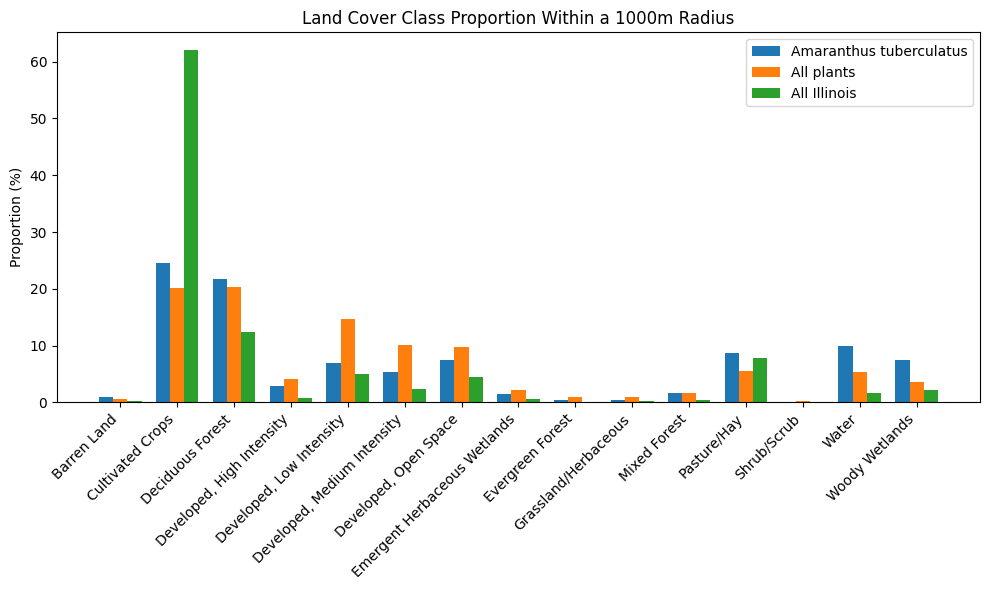

In [39]:
import matplotlib.pyplot as plt

x = np.arange(len(merged_df['lu_class']))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, merged_df['proportions_amaranthus'], width, label='Amaranthus tuberculatus')
ax.bar(x, merged_df['proportions_all_plants'], width, label='All plants')
ax.bar(x + width, merged_df['proportions_illinois'], width, label='All Illinois')
ax.set_xticks(x)
ax.set_xticklabels(merged_df['lu_class'], rotation=45, ha='right')
ax.set_ylabel('Proportion (%)')
ax.set_title('Land Cover Class Proportion Within a 1000m Radius')
ax.legend()

plt.tight_layout()
plt.show()


In [101]:
# entire workflow for gbif_data

def add_observation_land_use_data():
    df = pd.read_csv('..\\data\\0001075-250213122211068.csv', delimiter='	')
    filtered_df = df.dropna(subset=['decimalLongitude', 'decimalLatitude'])
    filtered_df = filtered_df[filtered_df["year"] < 2024]

    gdf = create_buffers(filtered_df, radius=1000)
    gdf = gdf.to_crs(custom_crs)
    gdf['buffers'] = gdf['buffers'].to_crs(custom_crs)


    new_columns = ["land_cover_class", "top_class_300m", "proportion_agricultural_300m", "shannon_idx_300m"]
    for col in new_columns:
        filtered_df[col] = None

    for idx, row in gdf.iterrows():
        raster_path = f"..\\nlcd_data\\Annual_NLCD_LndCov_{row['year']}_CU_C1V0.tif"
        point = row.geometry
        with rasterio.open(raster_path) as src:
            coord = [(point.x, point.y)]
            pixel_value = next(src.sample(coord))[0]
            filtered_df.at[idx, 'land_cover_class'] = str(nlcd_classes.get(pixel_value, None))

    year_groups = gdf.groupby('year')
    for year, group in year_groups:
        raster_path = f"..\\nlcd_data\\Annual_NLCD_LndCov_{year}_CU_C1V0.tif"

        buffer_gdf = gpd.GeoDataFrame(
            {'geometry': group['buffers'].values}, index=group.index, crs=custom_crs)
        buffer_gdf = buffer_gdf.to_crs(custom_crs)

        proportions = nlcd_zonal_stats(buffer_gdf, raster_path)
        
        for i, (idx, _) in enumerate(group.iterrows()):
            if i < len(proportions) and proportions[i]:
                prop_dict = proportions[i]

                if len(prop_dict) > 1:
                    land_classes = {k: v for k, v in prop_dict.items() if k != 'shannon_index'}
                    top_class = max(land_classes.items(), key=lambda x: x[1], default=(None, 0))[0]
                    filtered_df.at[idx, 'top_class_300m'] = str(top_class)
                    
                    agricultural_classes = ['Cultivated Crops', 'Pasture/Hay']
                    agricultural_prop = sum(prop_dict.get(cls, 0) for cls in agricultural_classes)
                    filtered_df.at[idx, 'proportion_agricultural_300m'] = agricultural_prop
                
                # Get shannon index
                filtered_df.at[idx, 'shannon_idx_300m'] = prop_dict.get('shannon_index', 0)
    
            # row_gdf = gpd.GeoDataFrame([row], columns=gdf.columns, crs=gdf.crs)
            # buffer_geometry = row['buffers']
            
            # buffer_geojson = gpd.GeoSeries([buffer_geometry], crs=custom_crs).__geo_interface__
            # buffer_wkt = buffer_geometry.wkt
            
            # # try with GeoJSON first, then WKT
            # proportions = nlcd_zonal_stats(buffer_geojson, raster_path)
            # if not proportions or all(len(p) <= 1 for p in proportions):
            #     proportions = nlcd_zonal_stats(buffer_wkt, raster_path)
            
            #print(proportions)
            # Create a proper GeoDataFrame from the buffer geometry
            #buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_geometry], crs=custom_crs)

    df_combined = df.reindex(filtered_df.index)
    df_combined['land_cover_class'] = filtered_df['land_cover_class']
    filtered_df.to_csv('..\\1000m_amaranthus_with_proportions.csv')

    #print(df_combined['land_cover_class'].value_counts())
    df_combined.to_csv('..\\test_amaranthus_land_classes')

add_observation_land_use_data()


In [ ]:
# gdf_crop_data = gpd.read_file('..\\crop_data\\NationalCSB_2008-2015_rev23\\CSB0815.gdb')
# gdf_crop_data.head()

In [ ]:
human_mediated_df = pd.read_csv('..\\with_barren_land_classes - herbarium_contact_exsiccata_list_v1 (1).csv')
with_proportions_df = pd.read_csv('..\\1000m_amaranthus_with_proportions.csv')
with_proportions_df.index.name = 'index'
with_proportions_df = with_proportions_df.drop(columns=['Unnamed: 0'])

df1 = human_mediated_df.sort_values(by='gbifID').reset_index(drop=True)
df2 = with_proportions_df.sort_values(by='gbifID').reset_index(drop=True)

unique_cols_df2 = df2.columns.difference(df1.columns)
combined_df = pd.concat([df1, df2[unique_cols_df2]], axis=1)
print(combined_df['top_class_300m'].value_counts())
print(combined_df['land_cover_class'].value_counts())
print(combined_df['proportion_agricultural_300m'].mean())

combined_df.head()
combined_df.to_csv('..\\combined_with_proportions.csv')



top_class_300m
Cultivated Crops                169
Deciduous Forest                 80
Water                            60
Pasture/Hay                      58
Grassland/Herbaceous             47
Woody Wetlands                   47
Developed, Low Intensity         39
Developed, Medium Intensity      20
Developed, Open Space            11
Emergent Herbaceous Wetlands     10
Shrub/Scrub                       3
Developed, High Intensity         2
Evergreen Forest                  1
Name: count, dtype: int64
land_cover_class
Developed, Low Intensity        74
Cultivated Crops                71
Deciduous Forest                63
Woody Wetlands                  60
Developed, Open Space           50
Pasture/Hay                     46
Developed, Medium Intensity     41
Emergent Herbaceous Wetlands    39
Water                           31
Grassland/Herbaceous            29
Developed, High Intensity       17
Barren Land                     15
Evergreen Forest                 8
Shrub/Scrub        

In [102]:
threehundred_proportions = pd.read_csv('..\\amaranthus_with_proportions.csv')
print(threehundred_proportions['top_class_300m'].value_counts())


top_class_300m
Cultivated Crops                140
Deciduous Forest                 80
Woody Wetlands                   68
Water                            66
Grassland/Herbaceous             48
Pasture/Hay                      46
Developed, Low Intensity         27
Developed, Medium Intensity      24
Emergent Herbaceous Wetlands     20
Developed, Open Space            13
Developed, High Intensity         7
Shrub/Scrub                       4
Evergreen Forest                  2
Barren Land                       2
Name: count, dtype: int64
